# Neural network for number recognition
### by Karan

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import random

## 1. Prepare training and test data 

- Download the 4 files from: http://yann.lecun.com/exdb/mnist/
or https://www.tensorflow.org/datasets/catalog/mnist
- put them into the directory of this python notebook

### 1.1 Extract the data file: training images \\( \rightarrow \\) array: trainingIn

In [ ]:
with open("train-images-idx3-ubyte", "rb") as f:
    _ = f.read(16)
    
# We have 60,000 images with 28 x 28 pixels
imageSize = 28
numImages = 60000

# Read the first 16 bits of the file
f.read(16)

# Read the remaining bits for the information of the images
buf = f.read(imageSize * imageSize * numImages)
# Format and bring the pixelvalues in the range [0,1]
trainingIn = np.frombuffer(buf, dtype=np.uint8).astype(np.float32) / 256
# Seperate the long list of bits into the individual images
trainingIn = trainingIn.reshape(numImages,imageSize**2)

PermissionError: [Errno 13] Permission denied: 'train-images-idx3-ubyte'

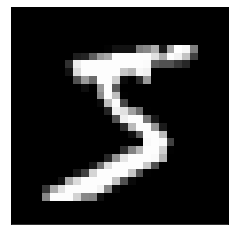

In [ ]:
# plot the first image
plt.xticks([])
plt.yticks([])
plt.imshow( trainingIn[0].reshape(imageSize, imageSize, 1), cmap='gray' )
plt.show()

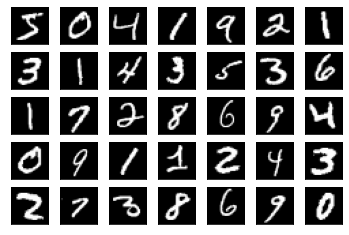

In [ ]:
# plot the first 35 images
for i in range(35):
    plt.subplot(5, 7, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow( trainingIn[i].reshape(imageSize, imageSize, 1), cmap='gray' )

plt.show()

In [ ]:
# add additional value '1' to the beginning of each image (necessary for the bias)
trainingIn = np.append(np.full([numImages, 1], 1), trainingIn, axis= 1)

### 1.2 Extract the data file: training labels \\( \rightarrow \\) array: trainingOut

In [ ]:
f = gzip.open('train-labels-idx1-ubyte.gz','r')

# Read the first 8 bits
f.read(8)

# Read the remaining bits that contain the information about the solution
buf = f.read(numImages)
trainingOut = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)

- The first 10 outputs

In [ ]:
trainingOut[0:10]

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4], dtype=int64)

- Problem: we need a 10 component vector like:\\( \quad\quad 5\rightarrow [0,0,0,0,0,1,0,0,0,0] \\)

In [ ]:
trainingOut = np.identity(10)[trainingOut]

In [ ]:
trainingOut[0:10]

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]])

### 1.3 Extract the data file: testing images \\( \rightarrow \\) array: testingIn

In [ ]:
f = gzip.open('t10k-images-idx3-ubyte.gz','r')

numImagesTest = 10000
testEnd = numImagesTest # Old nomenclature

f.read(16)
buf = f.read(imageSize * imageSize * numImagesTest)
testingIn = np.frombuffer(buf, dtype=np.uint8).astype(np.float32) / 256
testingIn = testingIn.reshape(numImagesTest,imageSize**2)
testingIn = np.append(np.full([numImagesTest, 1], 1), testingIn, axis= 1)

### 1.4 Extract the data file: testing labels \\( \rightarrow \\) array: testingOut

In [ ]:
f = gzip.open('t10k-labels-idx1-ubyte.gz','r')
f.read(8)
buf = f.read(numImagesTest)
testingOut = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
testingOut = np.identity(10)[testingOut]

## 2. Setting up the neural network

![Digit_network.png](Digit_network.png)

Input layer length: 28x28+1 (1 bias + 28x28 pixels)

Hidden layer length: 1 (10 neurons) \\( \rightarrow\\) We can change this value to improve performance

Output layer length: 10 (result catergories - 10 digits)

In [ ]:
### CHANGE ###

numLayers = [3,5,2]

### 2.1 Initialize weights: Numbers in the range from -2 to 2

- We need a starting point for our weights. Let's select them randomly.
- Be careful about the dimension of the arrays:

    - weights[0] connects the input layer with the hidden layer
    - weights[1] connects the hidden layer with the output layer

In [ ]:
weights = [
    4 * np.random.random_sample([numLayers[0],numLayers[1]]) - 2,
    4 * np.random.random_sample([numLayers[1],numLayers[2]]) - 2
    ]

### 2.2 Activation function

- Typically a monotonuous function that rescales a value to the range [0,1]
- Here we use the sigmoid function:

Activation function:
\\( a(x) = \frac{1}{1+\exp(-x)} \\)

Derivative:
\\( a'(x) = \frac{\exp(-x)}{\left[1+\exp(-x)\right]^2} \\)

In [ ]:
def activation(x):
    return 1 / (1 + np.exp(-x))

def activationDerivative(x):
    return np.exp(-x) / (1 + np.exp(-x))**2

x = np.linspace(-5,5,101)
y1 = activation(x)
y2 = activationDerivative(x)
plt.plot(x, y1, label='activation function a(x)')
plt.plot(x, y2, label="derivative a'(x)")
plt.legend()
plt.show()

### 2.3 Calculate output of our neural network

The value of a neuron is given as the dot product of the two vectors: 
- weights 
- value of the neurons in the previous layer (including bias: value 1)

This value is then rescaled by the activation function.

First, calculate the hidden layer:
\\( h_i = a\left(w_{0i}^{(0)}x_0 + w_{1i}^{(0)}x_1 + w_{2i}^{(0)}x_2 + \ldots\right) \\)

Then, calculate the output layer:
\\( y_j = a\left(w_{0j}^{(1)}h_1 + w_{1j}^{(1)}h_1 + w_{2j}^{(1)}h_2 + \ldots \right) \\)

In [ ]:
def calculateNext(x,w):
    # x: input
    # w: weights
    return activation( np.dot(x,w) )

In [ ]:
# testing: apply the function twice to directly calculate the output
testIndex = 50
calculateNext(
    calculateNext( trainingIn[testIndex], weights[0] ),
    weights[1]
)

In [ ]:
# even works if we feed it all the images at the same time
calculateNext(
    calculateNext( trainingIn, weights[0] ),
    weights[1]
)

- highest value would predict the output digit

The calculation of one of these output values corresponds to:

\\( y_j = a\Big[w_{0j}^{(1)}a\left(w_{00}^{(0)}x_0 + w_{10}^{(0)}x_1 + w_{20}^{(0)}x_2+\ldots\right) \\ \quad\quad + w_{1j}^{(1)}a\left(w_{01}^{(0)}x_0 + w_{11}^{(0)}x_1 + w_{21}^{(0)}x_2+\ldots\right) \\ \quad\quad + w_{2j}^{(1)}a\left(w_{02}^{(0)}x_0 + w_{12}^{(0)}x_1 + w_{22}^{(0)}x_2+\ldots\right) \\ \quad\quad + w_{3j}^{(1)}a\left(w_{03}^{(0)}x_0 + w_{13}^{(0)}x_1 + w_{23}^{(0)}x_2+\ldots\right) \\ \quad\quad + w_{4j}^{(1)}a\left(w_{04}^{(0)}x_0 + w_{14}^{(0)}x_1 + w_{24}^{(0)}x_2+\ldots\right) \\\quad\quad + w_{5j}^{(1)}a\left(w_{05}^{(0)}x_0 + w_{15}^{(0)}x_1 + w_{25}^{(0)}x_2+\ldots\right)+\ldots \Big] \\)

### 2.4 Functions: Calculate accuracy and individual error

### - Accuracy: 
What is the rate at which an image is recognized correctly (only correct and wrong matter)?

In [ ]:
def accuracy(testingIn,testingOut,weights):
    return 1 - np.sum(
            np.abs(
                np.sign(
                    np.abs(testingOut.argmax(axis=1) - calculateNext(calculateNext(testingIn, weights[0]), weights[1]).argmax(axis=1))
                )
            )
        ) / testEnd

In [ ]:
accuracy(testingIn,testingOut,weights)

- So far, it is random: Chance to be correct 10\%

In [ ]:
# First 35 images
for i in range(35):
    plt.subplot(5, 7, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow( testingIn[i,1:].reshape(imageSize, imageSize, 1), cmap='gray' )

plt.show()

In [ ]:
# Predicted outputs



### - Error (better for learning): 
For each image the 10 component output vector is compared to the correct 10 component output vector

\\( \Delta = (\vec{y}-\vec{Y})^2=\sum_j (y_j-Y_j)^2 \\)

\\( y_j \\): Predicted output of neuron \\( j \\) (Number between 0 and 1)

\\( Y_j \\): Correct result of neuron \\( j \\) (Number exactly 0 or 1)

In [ ]:
def error(predictedValues, correctValues):
    return np.sum( (predictedValues - correctValues)**2 )

In [ ]:
error(calculateNext(calculateNext( trainingIn[testIndex], weights[0] ),weights[1]), trainingOut[testIndex])

Or as one long formula

\\(\Delta = \sum_j \Big( a\Big[w_{0j}^{(1)}a\left(w_{00}^{(0)}x_0 + w_{10}^{(0)}x_1 + w_{20}^{(0)}x_2+\ldots\right) \\ \quad\quad\quad\quad + w_{1j}^{(1)}a\left(w_{01}^{(0)}x_0 + w_{11}^{(0)}x_1 + w_{21}^{(0)}x_2+\ldots\right) \\ \quad\quad\quad\quad + w_{2j}^{(1)}a\left(w_{02}^{(0)}x_0 + w_{12}^{(0)}x_1 + w_{22}^{(0)}x_2+\ldots\right) \\ \quad\quad\quad\quad + w_{3j}^{(1)}a\left(w_{03}^{(0)}x_0 + w_{13}^{(0)}x_1 + w_{23}^{(0)}x_2+\ldots\right) \\ \quad\quad\quad\quad + w_{4j}^{(1)}a\left(w_{04}^{(0)}x_0 + w_{14}^{(0)}x_1 + w_{24}^{(0)}x_2+\ldots\right) +\ldots\Big] -Y_j\Big)^2 \\)

### 2.5 Function: Calculate gradient (d Error / d weight)

- All derivatives with respect to the individual weights (Use chain rule)

\\( \frac{\partial }{\partial w_{ij}^{(1)}}\Delta = 2(y_j-Y_j) \cdot a'\left(w_{0j}^{(1)}h_0 + w_{1j}^{(1)}h_1 + w_{2j}^{(1)}h_2 + w_{3j}^{(1)}h_3 + w_{4j}^{(1)}h_4 +\ldots\right)\cdot a\left(w_{0i}^{(0)}x_0 + w_{1i}^{(0)}x_1 + w_{2i}^{(0)}x_2+\ldots\right)\\)

\\( \frac{\partial }{\partial w_{ki}^{(0)}}\Delta = \sum_j 2(y_j-Y_j) \cdot a'\left(w_{0j}^{(1)}h_0 + w_{1j}^{(1)}h_1 + w_{2j}^{(1)}h_2 + w_{3j}^{(1)}h_3 + w_{4j}^{(1)}h_4 +\ldots\right)\cdot w_{ij}^{(1)} \cdot a'\left(w_{0i}^{(0)}x_0 + w_{1i}^{(0)}x_1 + w_{2i}^{(0)}x_2+\ldots\right)\cdot x_k\\)

In [ ]:
# Slow because we use many loops
def gradient(x,w,correctValues):
    #
    dot = np.dot(x,w[0])
    hiddenValues = activation( dot ) 
    #hiddenValues = calculateNext( x, w[0] )
    hiddenValuesDerivative = activationDerivative( dot )
    hiddenValuesDerivative2 = activationDerivative(np.dot(hiddenValues,w[1]))
    diff = calculateNext(hiddenValues, w[1]) - correctValues
    #
    grad1 = np.array([
        2 * diff * hiddenValuesDerivative2 * hiddenValues[i]
        for i in range(numLayers[1])])
    grad0 = np.array([
        [ 2 * np.sum(
            diff[:] * hiddenValuesDerivative2[:] * w[1][i,:] * hiddenValuesDerivative[i] * x[k]
        ) for i in range(numLayers[1])] 
        for k in range(numLayers[0])])
    #
    return [grad0, grad1]

We can improve performance drastically by using matrix multiplication:

\\( \rightarrow \\) Calculate the whole array at once, instead of calculating every element individually

## 3. Training: Use Gradient descent to change weights to minimize the error

Repeat the following process many time:
- Select a random image (index)
- Calculate the gradient of the error 
- Change weights accoding to 

\\( w_\mathrm{new} = w_\mathrm{old} - learingRate\cdot gradient\\)

In [ ]:
learningRate = 0.001
steps = 100

# for documentation
errorList = [error(calculateNext(calculateNext(trainingIn[testIndex], weights[0]), weights[1]), trainingOut[testIndex])]
# weightList = [weights]

In [ ]:
for i in range(steps):
    # pick random input
    index = np.random.randint(numImages)
    # update weights (go along opposite gradient)
    grad = gradient(trainingIn[index], weights, trainingOut[index])
    weights[0] = weights[0] - learningRate*grad[0]
    weights[1] = weights[1] - learningRate*grad[1]
    # weightList.append( weights )
    # calculate new error
    er = error(calculateNext(calculateNext(trainingIn[index], weights[0]), weights[1]), trainingOut[index])
    errorList.append( er )

In [ ]:
errorList

In [ ]:
plt.scatter(range(steps+1),errorList)

## 4. Application to test data set (new data)

In [ ]:
for i in range(35):
    plt.subplot(5, 7, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow( testingIn[i,1:].reshape(imageSize, imageSize, 1), cmap='gray' )

plt.show()

In [ ]:
accuracy(testingIn,testingOut,weights)

## 5. Add on 

What are the features that the neural network is looking for?